**IMPORTING NECESSARY LIBRARIES**

In [2]:
import numpy as np 
import pandas as pd 
import torch
import math
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import seaborn as sn
import json

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline

**UNDERSTANDING THE DATA**

In [3]:
#credits - https://www.kaggle.com/ihelon/cassava-leaf-disease-exploratory-data-analysis

direc = "../input/cassava-leaf-disease-classification/"

with open(os.path.join(direc, "label_num_to_disease_map.json")) as file:
    map_classes = json.loads(file.read())
    map_classes = {int(k) : v for k, v in map_classes.items()}

input_files = os.listdir(os.path.join(direc, "train_images"))
print("Number of train images:",len(input_files))

df_train = pd.read_csv(os.path.join(direc, "train.csv"))

df_train["class_name"] = df_train["label"].map(map_classes)
print(map_classes)
df_train.head()

Number of train images: 21397
{0: 'Cassava Bacterial Blight (CBB)', 1: 'Cassava Brown Streak Disease (CBSD)', 2: 'Cassava Green Mottle (CGM)', 3: 'Cassava Mosaic Disease (CMD)', 4: 'Healthy'}


,image_id,label,class_name
0,1000015157.jpg,0,Cassava Bacterial Blight (CBB)
1,1000201771.jpg,3,Cassava Mosaic Disease (CMD)
2,100042118.jpg,1,Cassava Brown Streak Disease (CBSD)
3,1000723321.jpg,1,Cassava Brown Streak Disease (CBSD)
4,1000812911.jpg,3,Cassava Mosaic Disease (CMD)


3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

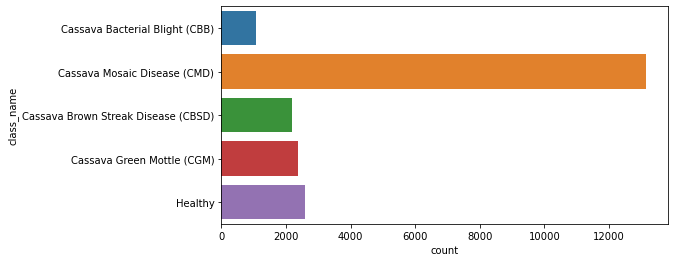

In [4]:
plt.figure(figsize=(8, 4))
sn.countplot(y="class_name", data=df_train);

df_train.label.value_counts()

**LOADING DATASETS AND RUNNING AUGMENTATIONS**

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
                                rotation_range=270,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                brightness_range=[0.1,0.9],
                                shear_range=25,
                                zoom_range=0.3,
                                channel_shift_range=0.1,
                                horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1/255,
                                validation_split=0.2
)

valid_gen = ImageDataGenerator(
                               rescale=1/255,
                               validation_split = 0.2
)

IMG_SIZE, BATCH_SIZE = 312, 32
df_train["label"] = df_train["label"].astype(str)
tr_dataset = data_gen.flow_from_dataframe(
                            dataframe=df_train,
                            directory = direc + "train_images",
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = True,
                            subset = "training",
)

valid_dataset = valid_gen.flow_from_dataframe(
                            dataframe=df_train,
                            directory = direc + "train_images",
                            x_col = "image_id",
                            y_col = "label",
                            target_size = (IMG_SIZE, IMG_SIZE),
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = False,
                            subset = "validation"
)


Found 17118 validated image filenames belonging to 5 classes.
Found 4279 validated image filenames belonging to 5 classes.


**DATA VISUALIZATION**

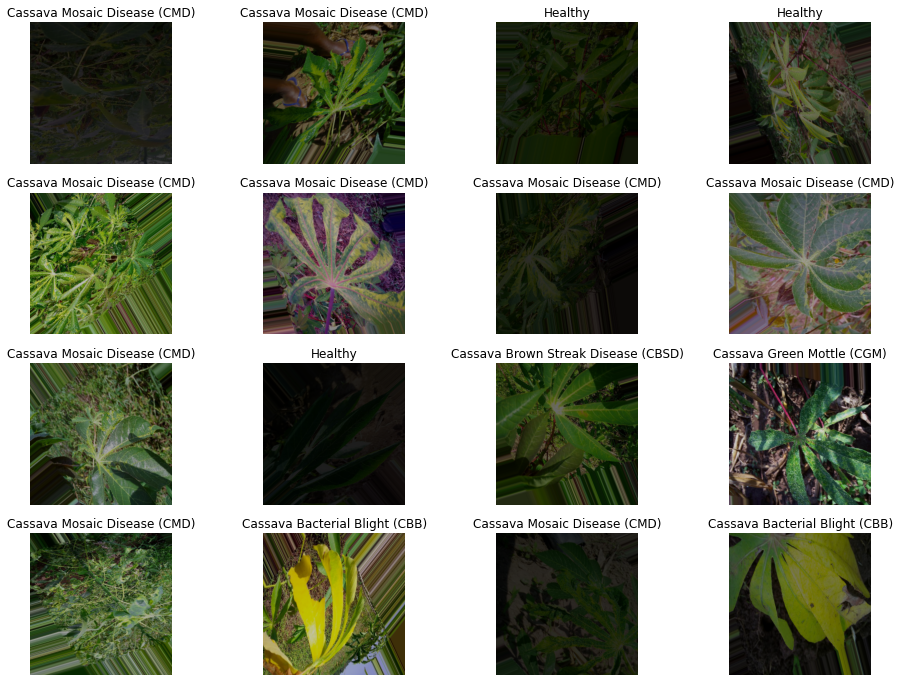

In [24]:
for i,(images,labels) in enumerate(tr_dataset):
    plt.figure(figsize = (16,12))
    for j in range(16):
        plt.subplot(4,4,j+1)
        plt.axis("off")
        plt.imshow(images[j])
        plt.title(map_classes[np.argmax(labels[j])])
    break

**CREATING A MODEL**

In [7]:
def customModel(weights = None):
    
    base_model = keras.applications.InceptionResNetV2(include_top = False,weights = weights, input_shape = [IMG_SIZE,IMG_SIZE,3])
    model = Sequential()
    model.add(base_model)
    model.add(BatchNormalization(axis=-1))
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(256,activation = "relu"))
    model.add(Dense(5, activation = "softmax"))
    
    model.compile(loss = "categorical_crossentropy", optimizer = Adam(lr = 0.001), metrics = ["acc"])
    return model

In [8]:
model = customModel(weights = "imagenet")
#model.summary()

219062272/219055592 [==============================] - 2s 0us/step


**TRAINING THE MODEL**

In [10]:
#LEARNING RATE SCHEDULER
def lr_scheduler(epoch,lr):
    if epoch > 3:
        return lr/1.125
    return lr

early_stopping = EarlyStopping(monitor = "acc", mode = "max",patience = 7)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)
check_point = tf.keras.callbacks.ModelCheckpoint("./CasavaLeafDiseaseDetectModel.h5", 
                                               monitor='val_loss',save_best_only=True)
history = model.fit(tr_dataset,
                    validation_data = valid_dataset,
                    epochs = 25,
                    callbacks = [early_stopping, lr_scheduler, check_point]
                   )

Epoch 1/25
535/535 [==============================] - 924s 2s/step - loss: 0.8517 - acc: 0.6924 - val_loss: 0.8989 - val_acc: 0.6815
Epoch 2/25
535/535 [==============================] - 838s 2s/step - loss: 0.6915 - acc: 0.7521 - val_loss: 0.7862 - val_acc: 0.7125
Epoch 3/25
535/535 [==============================] - 820s 2s/step - loss: 0.6499 - acc: 0.7644 - val_loss: 0.5613 - val_acc: 0.7836
Epoch 4/25
535/535 [==============================] - 836s 2s/step - loss: 0.6029 - acc: 0.7841 - val_loss: 0.5850 - val_acc: 0.7841
Epoch 5/25
535/535 [==============================] - 818s 2s/step - loss: 0.5480 - acc: 0.8034 - val_loss: 0.5337 - val_acc: 0.8147
Epoch 6/25
535/535 [==============================] - 791s 1s/step - loss: 0.5219 - acc: 0.8167 - val_loss: 0.4690 - val_acc: 0.8327
Epoch 7/25
535/535 [==============================] - 758s 1s/step - loss: 0.5134 - acc: 0.8175 - val_loss: 0.6291 - val_acc: 0.7964
Epoch 8/25
535/535 [==============================] - 723s 1s/step - 

**PLOTTING LEARNING CURVES**

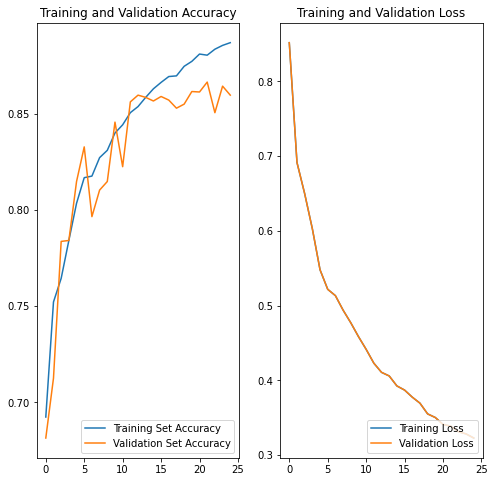

In [16]:
acc = history.history["acc"]
v_acc = history.history["val_acc"]

loss = history.history["loss"]
v_loss = history.history["loss"]

epochs = range(25)

plt.figure(figsize = (8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label = "Training Set Accuracy")
plt.plot(epochs, v_acc, label = "Validation Set Accuracy")
plt.legend(loc = "lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label = "Training Loss")
plt.plot(epochs, v_loss, label = "Validation Loss")
plt.legend(loc = "lower right")
plt.title("Training and Validation Loss")
plt.show()

In [ ]:
model = model = tf.keras.models.load_model("../input/casavaleafdiseasemodel-tf/CasavaLeafDiseaseModel_epoch_12_acc_85.h5")

**TEST IMAGES PREDICTION AND SUBMISSION**

In [29]:
preds = []
test_direc = direc + "test_images/"
sample_sub_csv = pd.read_csv('../input/cassava-leaf-disease-classification/sample_submission.csv')

for image in sample_sub_csv.image_id:
    img = tf.keras.preprocessing.image.load_img('../input/cassava-leaf-disease-classification/test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.reshape(img, (-1, IMG_SIZE, IMG_SIZE, 3))
    prediction = model.predict(img/255)
    preds.append(np.argmax(prediction))

final_submission = pd.DataFrame({'image_id': sample_sub_csv.image_id, 'label': preds})
final_submission.to_csv('submission.csv', index=False) 

In [30]:
print(final_submission.head())

         image_id  label
0  2216849948.jpg      4
